In [1]:
import torch
from torch import nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Testdaten laden und vorbereiten

In [4]:
data_dir = 'data/flowers'

# Define transforms for the testing data
test_transforms = transforms.Compose([
                                    transforms.Resize(225),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()
                                   ])
# Pass transform and get augmanted data here
test_data = datasets.ImageFolder(data_dir+'/test', transform=test_transforms)
# prepare data loaders (combine dataset and sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data))

In [3]:
print("Number of test data     :", len(test_data))

Number of test data     : 66


### Zeigt einige Beispielbilder aus vorbereiteten Testdaten

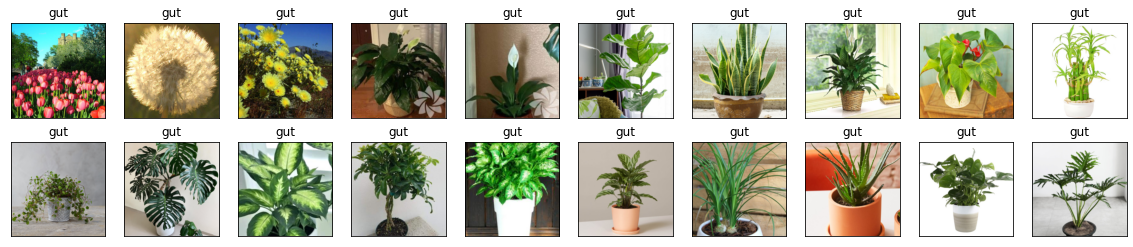

In [6]:
# specify the image classes
classes = ['gut', 'durstig']

# get one batch of training images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot some images with corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
#     plt.imshow(images[idx])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### Model definieren und seine Parametern einfrieren

In [8]:
model = models.densenet121(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

### Gerät definieren

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Model will work on {device.type}.")

Model will work on cpu.


In [12]:
model.classifier = nn.Sequential(
                                 nn.Linear(1024, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 2),
                                 nn.LogSoftmax(dim=1)
                                )
# NLLLoss: The negative log likelihood loss.
criterion = nn.NLLLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)

model.to(device);

### Trainertes Model Laden

In [14]:
model.load_state_dict(torch.load('model_290522_2114.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

### Prüfe Das Model

In [34]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
# Accumulate mispredicted pictures
mispred_pictures = list()
# Accumulate mispredicted picture infos
info_mispreds = list()

model.eval()
# iterate over test data
for inputs, labels in test_loader:
    # move tensors to GPU if CUDA is available
    inputs, labels = inputs.to(device), labels.to(device)
    # forward pass
    logprobs = model.forward(inputs)    
    # calculate the batch loss
    batch_loss = criterion(logprobs, labels)
    # update test loss
    test_loss += batch_loss.item()*inputs.size(0)
    # change negative probabilities to positive numbers
    probs = torch.exp(logprobs)
    # get top probabilities and their indexes
    top_scrs, top_idxes = probs.topk(1, dim=1)
    # create boolean mask for idxes as True, False format
    equals = (top_idxes == labels.view(*top_idxes.shape)).squeeze()    
    # fill class_correct and class_total lists
    for i in range(inputs.size(0)):
        label = labels.data[i]
        class_correct[label] += equals[i].item()
        class_total[label] += 1
    # get misspredicted pictur indexes    
    misspred = (equals == 0).nonzero()
    # save that pictures and their predictions
    for idx in misspred:
        mispred_picture = inputs[idx]#.numpy().squeeze()        
        prediction = top_idxes[idx].item()
        real = labels[idx].item()
        mispred_pictures.append(mispred_picture)
        info_mispreds.append([prediction, real, top_scrs[idx].item(), idx])        
# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
# print accuracy of each type of inputs
for i in range(2):
    if class_total[i] > 0:
        print(
              f'Test Accuracy of {classes[i]:s}: '
              f'{100 * class_correct[i] / class_total[i]:.2f} '
              f'({np.sum(class_correct[i]):.0f}/{np.sum(class_total[i]):.0f})'
             ) 
    else:
        print(f'Test Accuracy of {classes[i]:s}: N/A (no training examples)')

print(
      f'\nTest Accuracy (Overall): '
      f'{100. * np.sum(class_correct) / np.sum(class_total):.2f}' 
      f'({np.sum(class_correct):.0f}/{np.sum(class_total):.0f})'
     )

Test Loss: 0.249277

Test Accuracy of gut: 96.97 (32/33)
Test Accuracy of durstig: 93.94 (31/33)

Test Accuracy (Overall): 95.45(63/66)


In [48]:
info_mispreds

[[1, 0, 0.8799819350242615, tensor([3])],
 [0, 1, 0.5846832990646362, tensor([37])],
 [0, 1, 0.9904848337173462, tensor([38])]]

In [35]:
type(mispred_pictures[0])

torch.Tensor

### Zeige falsch klassifizierte Bilder an

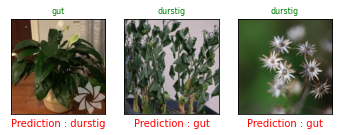

In [38]:
# plot some images with corresponding labels
fig = plt.figure(figsize=(20, 4))
# display 20 images
for i in range(len(mispred_pictures)):
    ax = fig.add_subplot(2, 10, i+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(mispred_pictures[i].numpy().squeeze(), (1, 2, 0)))
    ax.set_title(classes[info_mispreds[i][1]], color='g', fontsize=8)
    plt.xlabel(f"Prediction : {classes[info_mispreds[i][0]]:^s}", color='r')    

### Das Histogramm der Scores

In [39]:
scores

array([0.92090899, 0.97248578, 0.87399143, 0.87998194, 0.54189742,
       0.85023886, 0.97525191, 0.98976606, 0.88251185, 0.9660868 ,
       0.95884609, 0.98183733, 0.97615677, 0.93676573, 0.96131313,
       0.97865272, 0.93342537, 0.91419184, 0.90503478, 0.99021989,
       0.97802734, 0.87705004, 0.94291729, 0.83709264, 0.98561674,
       0.93100375, 0.89836299, 0.96485138, 0.94218749, 0.99006677,
       0.81085593, 0.99002177, 0.71710938, 0.9493193 , 0.98337018,
       0.85967541, 0.91644973, 0.5846833 , 0.99048483, 0.76396233,
       0.71613139, 0.96840739, 0.94652927, 0.71429515, 0.98441178,
       0.98141003, 0.56806582, 0.89742362, 0.88637137, 0.97409236,
       0.72448337, 0.51193017, 0.8823095 , 0.81956673, 0.97605246,
       0.67948687, 0.95832324, 0.88317138, 0.85063195, 0.55467081,
       0.8633396 , 0.91850382, 0.91649151, 0.90050912, 0.79431993,
       0.68642998])

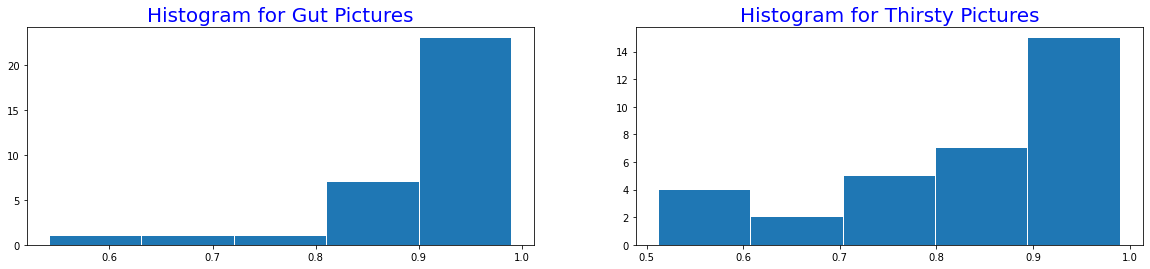

In [40]:
# plot some images with corresponding labels
fig = plt.figure(figsize=(20, 4))
ax = fig.add_subplot(1, 2, 1)
plt.hist(scores[:33], bins=5, rwidth=0.99)
ax.set_title("Histogram for Gut Pictures", color='b', fontsize=20)
ax = fig.add_subplot(1, 2, 2)
plt.hist(scores[33:], bins=5, rwidth=0.99)
ax.set_title("Histogram for Thirsty Pictures", color='b', fontsize=20)
plt.show()

## Interpretation

In [41]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [85]:
img_idx = 1
input = mispred_pictures[img_idx]
input.requires_grad = True

In [78]:
info_mispreds[img_idx]

[0, 1, 0.5846832990646362, tensor([37])]

In [79]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=info_mispreds[0][1],
                                              **kwargs
                                             )
    
    return tensor_attributions

In [80]:
saliency = Saliency(model)
grads = saliency.attribute(input, target=info_mispreds[img_idx][1])
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))

In [81]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.1019], dtype=torch.float64)


In [82]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      nt_samples=100)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

RuntimeError: [enforce fail at C:\cb\pytorch_1000000000000\work\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 16056320000 bytes.

In [83]:
dl = DeepLift(model)
attr_dl = attribute_image_features(dl, input, baselines=input * 0)
attr_dl = np.transpose(attr_dl.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

RuntimeError: Output 0 of BackwardHookFunctionBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is forbidden. You can fix this by cloning the output of the custom Function.

Original Image
Predicted: gut  Probability: 0.5846832990646362


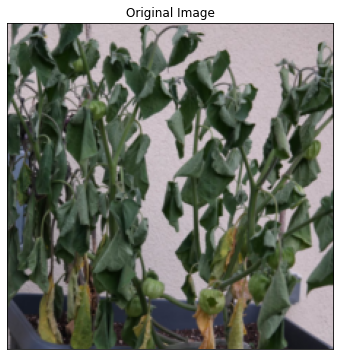

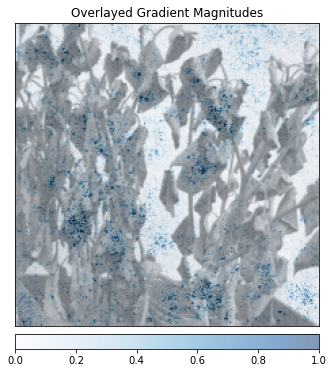

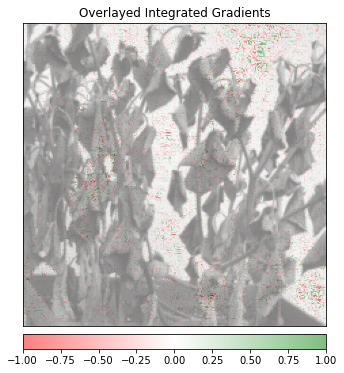

In [87]:
print('Original Image')
print('Predicted:', classes[info_mispreds[img_idx][0]], 
      ' Probability:', info_mispreds[img_idx][2])

# original_image = np.transpose((mispred_pictures[0].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))
original_image = np.transpose(mispred_pictures[img_idx].squeeze().cpu().detach().numpy(),(1, 2, 0)) 
_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

# _ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
#                              outlier_perc=10, show_colorbar=True, 
#                              title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

# _ = viz.visualize_image_attr(attr_dl, original_image, method="blended_heat_map",sign="all",show_colorbar=True, 
#                           title="Overlayed DeepLift")

In [74]:
mispred_pictures[0].squeeze().shape

torch.Size([3, 224, 224])